# Produce dataset using quadrants with no leakage, for 4 fold stratified CV (incl. downsampling and upsampling as reqd.), with an 'empty' image class
- Split images Shila has provided into 4 quadrants based on location in original large image
    - Ignore cells whose MAX_IMAGE_SIZExMAX_IMAGE_SIZE images may overlap between quadrants **(no leakage)**
        - Note, altho taking in '100' images, these images are *actually much larger*, so the max image size we may later use in classification is used here, and *resizing must be done later*
    - Produces **4 folds** for later training
        - TOP LEFT = Q1, TOP RIGHT = Q2, BOTTOM LEFT = Q3, BOTTOM RIGHT = Q4
- Take a sample within each quadrant of tumour + non tumour cells for binary classfication
    - **Stratified** by cell group (immune, connective, early stage cancer, etc.), and by cell type (if immune cell group has 7 cell subtypes, each subtype should make up 1/7 of images taken)
    - Split evenly between binary groups (e.g. for immune, with 1000 total images desired from a quadrant. 1000/2 = 500 from non-tumour cells. 500/3 = ~150 from each of 3 subgroups. 150/7 from each of 7 immune cell types)
    - **Downsample** or **upsample** to meet this requirement, if possible
- Output these + visualise these as we go, **copy final images to new folder as train/test data**
    - Also add a THIRD (multiclass) class with empty images

### Customisable Parts can be seen through constants below

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import sys
import os
import math
import PIL
import random

# constants
TOTAL_SAMPLE_SIZE = 1000 # how many images in tumour group + non tumour group (per fold)
RANDOM_SEED = 3888 # for reproducibility
MAX_IMAGE_SIZE = 224 # whats the biggest image size we will use?
BIG_IMAGE_PATH = os.path.join("projectdata", "metadata_code", "GSM7780153_Post-Xenium_HE_Rep1.ome.tif") # path to the big .tif image of all cells
# below constants are not used until last section of code, for outputting images
IMAGE_SIZE = "100" # as in which input image size (50 or 100) is to be used
IMAGE_DIR = os.path.join("projectdata", "images", IMAGE_SIZE) # path to images
OUTPUT_BASE = os.path.join("projectdata", "images", f"{IMAGE_SIZE}_stratified4fold_{TOTAL_SAMPLE_SIZE}per_seed{RANDOM_SEED}") # path to output images
GENERATE_DATA = True
EMPTY_CLASS_SIZE = 100 # how many empty/white images to use per fold?  
# IF THIS IS CHANGED, MUST INSPECT BIG IMAGE TO MAKE SURE NEW CUTOFFS STILL ONLY IN WHITE AREA (see end of document), and also below
if int(math.sqrt(EMPTY_CLASS_SIZE)) ** 2 != EMPTY_CLASS_SIZE:
    raise ValueError("EMPTY_CLASS_SIZE must be a perfect square.")

# setting up the environment
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print(sys.version)

3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


## Using pre-written code "MohanGuo/datasplit.py" to split data
Adjustments:
- **SPLITTING CELLS BASED ON BIG IMAGE, NOT ON MEDIAN OF CELL LOCATIONS**
    - this ensures ONLY DATA FROM .tif (nothing from cell boundaries) used in this split
    - so this faithfully replicates split on incoming data
- Using mean of values for cell boundaries, not the first value
- Dropping all images that might overlap between quadrants, by adjusting the cuttoff values for each quadrant. THESE ARE GIVEN TO Q0.
- Changed how the IMAGE_DIR + OUTPUT_BASE direcftories are generated, to allow for 50x50 pix image data to be used if desired
- Just going to keep it all in memory for now

This is Eric's code.

In [27]:
# Load coordinate files
cbr = pd.read_csv("projectdata/metadata_code/cbr.csv")  # Contains index, axis-0, axis-1
meta = pd.read_excel("projectdata/metadata_code/41467_2023_43458_MOESM4_ESM.xlsx", sheet_name=1)  # Contains cell_id and Cluster

# Merge cell ID and annotation
meta["index"] = meta.index + 1  # Ensure cell_id matches index
print(meta.head())
# image_df = pd.merge(cbr.drop_duplicates("index"), meta[["index", "Cluster"]], on="index")

# Take the average of duplicates for each row based on 'index'
print(cbr.head())
cbr_avg = cbr.groupby("index", as_index=False).mean()
print(cbr_avg.head())
image_df = pd.merge(cbr_avg, meta[["index", "Cluster"]], on="index")
print(image_df.head()) # NOTE - axis-0/1 correspond to big .tif image coords, dunno what centroid values corresond to (maybe scaled, like microns or smth)

   Barcode  UMAP_DIM1  UMAP_DIM2         Cluster  transcript_counts  \
0        1        NaN        NaN          DCIS 2                 28   
1        2        NaN        NaN          DCIS 2                 94   
2        3  -1.795124   9.981263       Unlabeled                  9   
3        4        NaN        NaN  Invasive_Tumor                 11   
4        5        NaN        NaN          DCIS 2                 48   

   x_centroid  y_centroid  gene_counts  index  
0  847.259912  326.191365           15      1  
1  826.341995  328.031830           38      2  
2  848.766919  331.743187            8      3  
3  824.228409  334.252643            9      4  
4  841.357538  332.242505           33      5  
   index        axis-0       axis-1
0      1  20795.624215  8295.401252
1      1  20793.214569  8280.106238
2      1  20789.691155  8272.472663
3      1  20782.183747  8277.228385
4      1  20778.154228  8281.963210
   index        axis-0       axis-1
0      1  20783.537959  8287.5020

In [28]:

# # Get image space midpoint and divide into quadrants
# x_mid = image_df["axis-1"].median()
# y_mid = image_df["axis-0"].median()

# Increase the limit for large images
PIL.Image.MAX_IMAGE_PIXELS = None  # Set to None to remove the limit

big_image = PIL.Image.open(BIG_IMAGE_PATH)
width, height = big_image.size
x_mid, y_mid = width // 2, height // 2

big_image.close()
del big_image # free up memory

In [29]:

# Adjust midpoints to avoid data leakage
# if we take a cell, and its 224x224 neighbourhood, this might overlap with another quadrant
# so we dont consider this divided by 2 (image extends above and below centre of cells, and the 'axis-0' and 'axis-1' value has been aggregated by mean across cells)
x_mid_high = x_mid + MAX_IMAGE_SIZE/2
x_mid_low = x_mid - MAX_IMAGE_SIZE/2
y_mid_high = y_mid + MAX_IMAGE_SIZE/2
y_mid_low = y_mid - MAX_IMAGE_SIZE/2

def get_quadrant(row):
    if row["axis-1"] < x_mid_low and row["axis-0"] < y_mid_low:
        return "Q1"  # Top-left
    elif row["axis-1"] >= x_mid_high and row["axis-0"] < y_mid_low:
        return "Q2"  # Top-right
    elif row["axis-1"] < x_mid_low and row["axis-0"] >= y_mid_high:
        return "Q3"  # Bottom-left
    elif row["axis-1"] >= x_mid_high and row["axis-0"] >= y_mid_high:
        return "Q4"  # Bottom-right
    else:
        return "Q0"  # Cell is too close to quadrant boundaries

image_df["quadrant"] = image_df.apply(get_quadrant, axis=1)

In [30]:
print(x_mid, y_mid)
print(x_mid_high, x_mid_low, y_mid_high, y_mid_low)
print(image_df["axis-1"].min(), image_df["axis-1"].max())
print(image_df["axis-0"].min(), image_df["axis-0"].max())

15393 12120
15505.0 15281.0 12232.0 12008.0
5952.905699462583 26859.595389370454
6736.853637707163 21757.47116614583


## Using MohanGuo/quadrant_visualisation.ipynb to visualise quadrants

### Visualization of Cell Type Distribution in Each Fold (Q0-Q4)

Adjusted to match above, no other logical adjustments. Note this means dealing with the cell names, not file names, and only working with the df in memory (not importing files until later)

In [31]:
# # Define the images_4fold directory path
# base_dir = "projectdata/images/images_" + IMAGE_SIZE + "_4fold"

# # Check if the directory exists
# if not os.path.exists(base_dir):
#     print(f"Error: {base_dir} directory does not exist")
# else:
#     print(f"Found directory: {base_dir}")

In [32]:
cell_group_map = {
    # Immune
    "CD4+_T_Cells": "Immune",
    "CD8+_T_Cells": "Immune",
    "B_Cells": "Immune",
    "IRF7+_DCs": "Immune",
    "LAMP3+_DCs": "Immune",
    "Macrophages_1": "Immune",
    "Macrophages_2": "Immune",
    "Mast_Cells": "Immune",

    #hybrids
    "Stromal_and_T_Cell_Hybrid": "Hybrid",
    "T_Cell_and_Tumor_Hybrid": "Hybrid",
    # in metadata spreadsheets, hybrid has & not 'and's, so need these keys to account for that
    "Stromal_&_T_Cell_Hybrid": "Hybrid",
    "T_Cell_&_Tumor_Hybrid": "Hybrid",

    # Tumor
    "Prolif_Invasive_Tumor": "Tumor",
    "Invasive_Tumor": "Tumor",

    #early stage cancer 
    "DCIS_1": "Early stage cancer",
    "DCIS_2": "Early stage cancer",
    # same as for hybrids, just underscores vs spaces 
    "DCIS 1": "Early stage cancer",
    "DCIS 2": "Early stage cancer",
    

    # Connective tissue
    "Stromal": "Connective tissue",
    "Perivascular-Like": "Connective tissue",
    "Myoepi_ACTA2+": "Connective tissue",
    "Myoepi_KRT15+": "Connective tissue",

    #endothelial
    "Endothelial": "Endothelial",

    # Unlabeled
    "Unlabeled": "Unlabeled"
}

In [33]:
# # Traverse the directory and count different cell types in each fold
# fold_cell_counts = {}

# # Assume directory structure as images_4fold/[fold]/[cell_type]/[images]
# for fold in os.listdir(base_dir):
#     fold_path = os.path.join(base_dir, fold)
    
#     if os.path.isdir(fold_path):
#         cell_counts = {}
        
#         for cell_type in os.listdir(fold_path):
#             cell_type_path = os.path.join(fold_path, cell_type)
            
#             if os.path.isdir(cell_type_path):
#                 # Calculate the number of images of this cell type
#                 image_count = len([f for f in os.listdir(cell_type_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
#                 cell_counts[cell_type] = image_count
        
#         fold_cell_counts[fold] = cell_counts

# Count different cell types in each fold using the dataframe 'image_df'
fold_cell_counts = {}

# Group by quadrant and Cluster to count the number of occurrences
grouped_df = image_df.groupby(['quadrant', 'Cluster']).size().reset_index(name='Count')

# Populate the fold_cell_counts dictionary
for _, row in grouped_df.iterrows():
    fold = row['quadrant']
    cell_type = row['Cluster']
    count = row['Count']
    
    if fold not in fold_cell_counts:
        fold_cell_counts[fold] = {}
    
    fold_cell_counts[fold][cell_type] = count

In [34]:
# Convert the data to DataFrame format for easier visualization
data_rows = []
for fold, cell_types in fold_cell_counts.items():
    for cell_type, count in cell_types.items():
        data_rows.append({'Fold': fold, 'Cell Type': cell_type, 'Count': count})

summary_df = pd.DataFrame(data_rows)

In [35]:
# Add the cell group to the DataFrame based on cell_group_map
summary_df['Cell Group'] = summary_df['Cell Type'].map(cell_group_map)

# Check if there are any NaN values in 'Cell Group' (indicating missing mappings)
if summary_df['Cell Group'].isnull().any():
    missing_types =summary_df[summary_df['Cell Group'].isnull()]['Cell Type'].unique()
    print("Warning: The following cell types do not have a group mapping:")
    print(missing_types)

# Aggregate counts by fold and cell group
group_counts = summary_df.groupby(['Fold', 'Cell Group'])['Count'].sum().reset_index()

### Cell Group Distribution For Each Quadrant

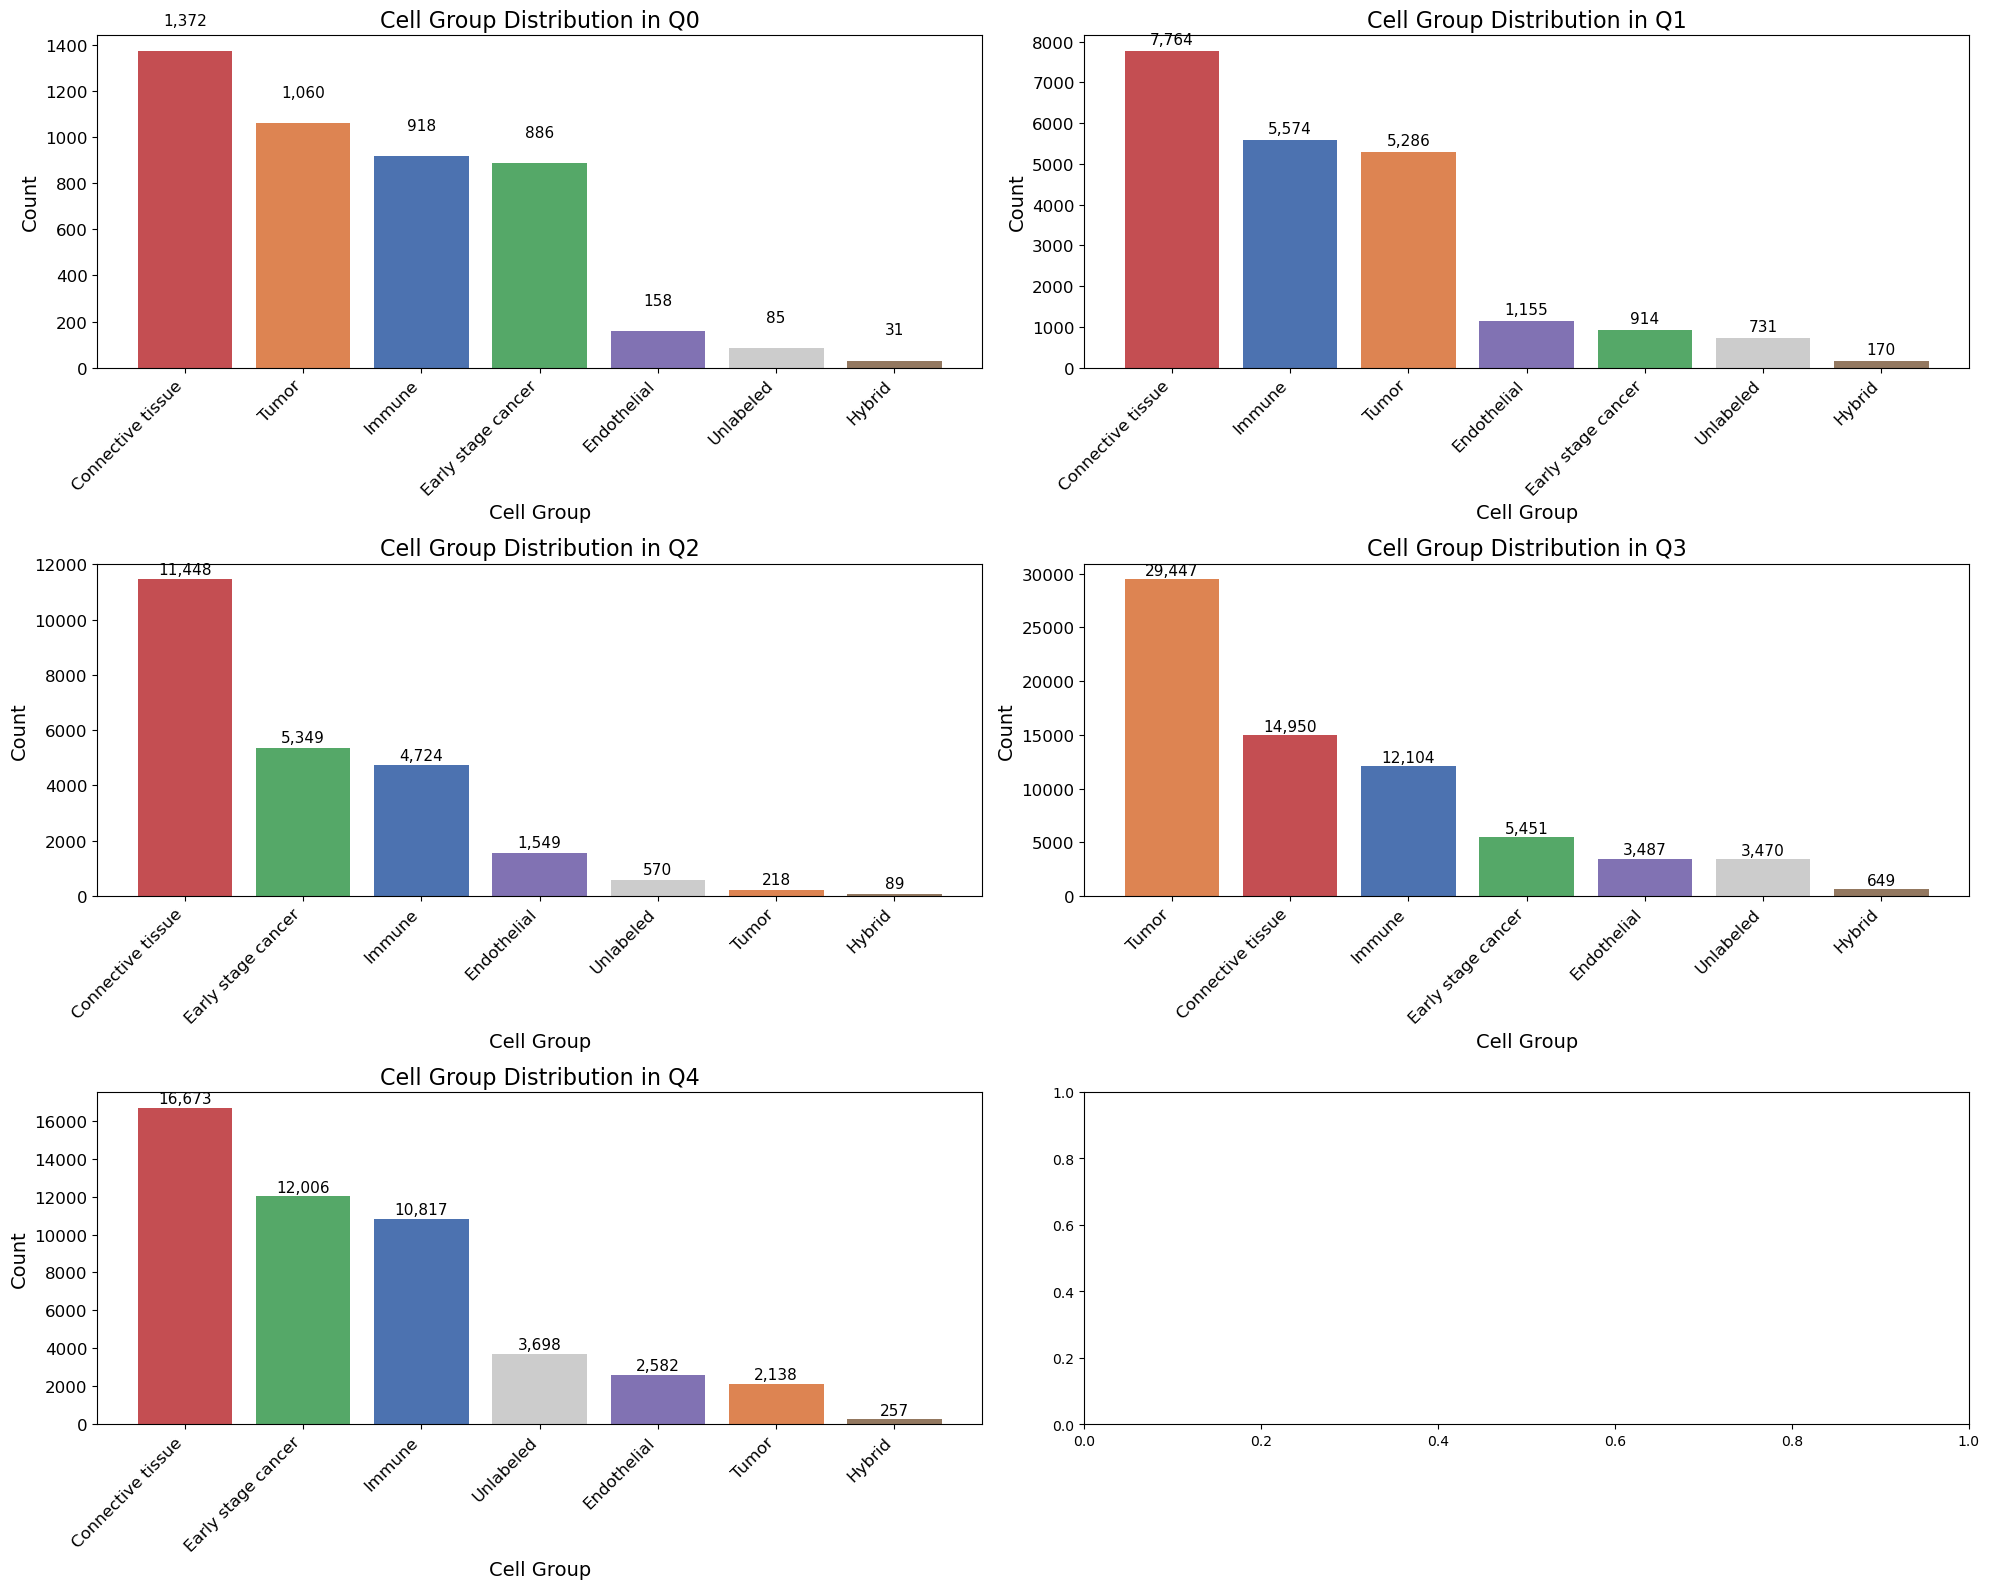

In [36]:
# Create separate plots for each fold (Q1-Q4) showing cell groups
fig, axes = plt.subplots(3, 2, figsize=(20, 16))
axes = axes.flatten()

folds = ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
colors = {
    'Immune': '#4C72B0',
    'Tumor': '#DD8452',
    'Early stage cancer': '#55A868',
    'Connective tissue': '#C44E52',
    'Endothelial': '#8172B3',
    'Hybrid': '#937860',
    'Unlabeled': '#CCCCCC'
}

for i, fold in enumerate(folds):
    # Filter data for the current fold
    fold_data = group_counts[group_counts['Fold'] == fold]
    
    # Sort by count for better visualization
    fold_data = fold_data.sort_values('Count', ascending=False)
    
    # Create the bar plot with custom colors
    bars = axes[i].bar(fold_data['Cell Group'], fold_data['Count'], color=[colors.get(group, '#CCCCCC') for group in fold_data['Cell Group']])
    
    # Set title and labels
    axes[i].set_title(f'Cell Group Distribution in {fold}', fontsize=16)
    axes[i].set_xlabel('Cell Group', fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    
    # Add count values on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 100,
                 f'{int(height):,}', ha='center', va='bottom', fontsize=11)
    
    # Set tick parameters
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

### Comparing Cell Distribution Across Folds

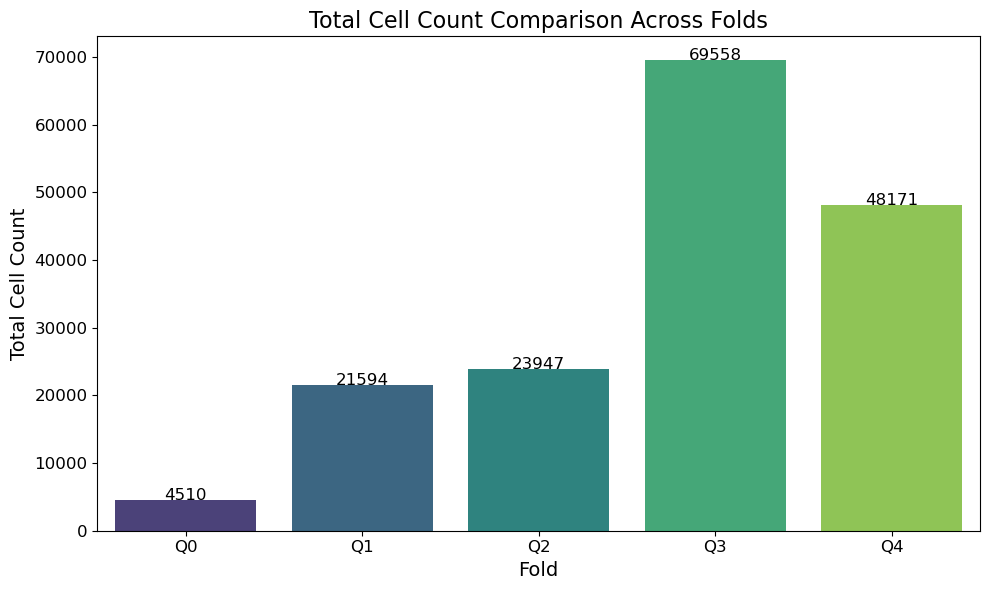

In [37]:
# Calculate the total number of cells in each fold
fold_totals = summary_df.groupby('Fold')['Count'].sum().reset_index()
# Create a bar chart to compare the total number of cells in each fold
plt.figure(figsize=(10, 6))
sns.barplot(x='Fold', y='Count', hue='Fold', data=fold_totals, palette='viridis', legend=False)
plt.title('Total Cell Count Comparison Across Folds', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Total Cell Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add numerical labels above each bar
for i, v in enumerate(fold_totals['Count']):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## Trying to run stratified down-sampling + upsampling (Q1-Q4, no Q0), and then visualising these, using binary classes
Procedure
- go over each fold
- go over each cell type, stratified with cell group + cell type, try get TOTAL_SAMPLE_SIZE/2 (upsampling if required) from each of tumour + non tumour
    get  TOTAL_SAMPLE_SIZE/2 from each group, further trying to make sure strafified by subgroup
    say non-tumour, we want 2000 images. 3 sub groups (immune, endo, connective), so 666 from each. immune has 7 subypes, so 666/7 from each.
- visualise these

Note, this involves 'sampling' from image_df, and then reproducing grouped/summary dfs based on this. If not enough images, just add what we have, and upsampling procedure considered later.

In [38]:
print(summary_df.head())

# drop Q0 (this is just for cells to drop)
summary_df = summary_df[summary_df["Fold"] != "Q0"]

# drop hybrid + unlabelled cell groups
summary_df = summary_df[~summary_df["Cell Group"].isin(["Hybrid", "Unlabeled"])]

print(summary_df.head())
print(image_df.head())


  Fold     Cell Type  Count          Cell Group
0   Q0       B_Cells    179              Immune
1   Q0  CD4+_T_Cells    248              Immune
2   Q0  CD8+_T_Cells    202              Immune
3   Q0        DCIS 1    790  Early stage cancer
4   Q0        DCIS 2     96  Early stage cancer
   Fold     Cell Type  Count          Cell Group
20   Q1       B_Cells    879              Immune
21   Q1  CD4+_T_Cells   1555              Immune
22   Q1  CD8+_T_Cells   1183              Immune
23   Q1        DCIS 1     12  Early stage cancer
24   Q1        DCIS 2    902  Early stage cancer
   index        axis-0       axis-1         Cluster quadrant
0      1  20783.537959  8287.502067          DCIS 2       Q3
1      2  20780.058221  8227.236189          DCIS 2       Q3
2      3  20770.997192  8293.148625       Unlabeled       Q3
3      4  20764.482893  8224.974469  Invasive_Tumor       Q3
4      5  20770.467129  8271.501109          DCIS 2       Q3


In [39]:
# manually calculated from above. number of keys in map cant be counted, as multiple punctuation versions exist
group_sizes = {"Immune": 8, "Hybrid": 2, "Tumor": 2, "Early stage cancer": 2, "Connective tissue": 4, "Endothelial":1, "Unlabeled":1}

# NOTE - HYRBID + UNLABELLED SHOULD NOT BE CONSIDERED HERE. the # of keys per group is used
group_to_binary_map = {"Immune": "Non-Tumor", "Tumor": "Tumor", "Early stage cancer": "Tumor", "Connective tissue": "Non-Tumor", "Endothelial":"Non-Tumor"}

summary_df['binary_group'] = summary_df['Cell Group'].map(group_to_binary_map)

image_df['binary_group'] = image_df['Cluster'].map(cell_group_map).map(group_to_binary_map)

In [40]:
# go over each fold
# go over each cell type, and downsamplee as reqd from each one (ignoring hybrid + unlabelled)
# Initialize a list to store sampled data
stratified_down_data = []
stratified_up_data = []
upsampling_required = {} # upsampled images will actually be produced later, so store how many more images needed for which folds/classes

# Iterate over each fold
for fold in summary_df['Fold'].unique():
    fold_data = summary_df[summary_df['Fold'] == fold]
    fold_image_data = image_df[image_df['quadrant'] == fold]
        
    # Sample data for each cell type in this fold
    for cell_type in fold_data['Cell Type'].unique():
        # find the desired number of images from this fold

        binary_group = group_to_binary_map[cell_group_map[cell_type]]
        # Count the number of subgroups in the binary group we are looking at
        count_sub_groups = sum(1 for k, v in group_to_binary_map.items() if v == binary_group)
        # divide total images per binary group (2000 per), then by numbe r of subgroups (say non-tumour, then 3 subgroups giving ~666), then by number of types in subgroup (say immune, 7 types, giving ~90 or wtvr)
        desired_count = math.ceil(((TOTAL_SAMPLE_SIZE/2)/count_sub_groups)/group_sizes[cell_group_map[cell_type]])
        
        cell_type_data = fold_image_data[fold_image_data['Cluster'] == cell_type]
        
        if len(cell_type_data) >= desired_count:
            stratified_down_data.append(cell_type_data.sample(n=desired_count, random_state=RANDOM_SEED, replace=False))
        else:
            print(f"Warning: Not enough data for {cell_type} in {fold}. Found {len(cell_type_data)} images, but needed {desired_count}.")
            stratified_down_data.append(cell_type_data)
            stratified_up_data.append(cell_type_data)
            upsampling_required[fold, cell_type] = desired_count

        

# Combine all sampled data into a single DataFrame
stratified_down_df = pd.concat(stratified_down_data)  
stratified_up_df = pd.concat(stratified_up_data)  
print(stratified_down_df.head())
print(upsampling_required)

       index        axis-0        axis-1  Cluster quadrant binary_group
40927  40928   9654.555954   6193.921746  B_Cells       Q1    Non-Tumor
41397  41398   9691.532646   6210.866127  B_Cells       Q1    Non-Tumor
81561  81562  11884.221296  11935.217606  B_Cells       Q1    Non-Tumor
65462  65463   7200.081528   9008.857362  B_Cells       Q1    Non-Tumor
65094  65095   7213.095468  10319.733682  B_Cells       Q1    Non-Tumor
{('Q1', 'DCIS 1'): 125, ('Q1', 'Mast_Cells'): 21, ('Q1', 'Myoepi_KRT15+'): 42, ('Q2', 'Prolif_Invasive_Tumor'): 125, ('Q3', 'DCIS 1'): 125}


### Revisualise produce data (before upsampling)

In [41]:
# Count different cell types in each fold using the dataframe 'stratified_down_df'
fold_cell_counts = {}

# Group by quadrant and Cluster to count the number of occurrences
grouped_df2 = stratified_down_df.groupby(['quadrant', 'Cluster']).size().reset_index(name='Count')

# Populate the fold_cell_counts dictionary
for _, row in grouped_df2.iterrows():
    fold = row['quadrant']
    cell_type = row['Cluster']
    count = row['Count']
    
    if fold not in fold_cell_counts:
        fold_cell_counts[fold] = {}
    
    fold_cell_counts[fold][cell_type] = count

# Convert the data to DataFrame format for easier visualization
data_rows = []
for fold, cell_types in fold_cell_counts.items():
    for cell_type, count in cell_types.items():
        data_rows.append({'Fold': fold, 'Cell Type': cell_type, 'Count': count})

summary_df2 = pd.DataFrame(data_rows)
print(summary_df2.head())

# Add the cell group to the DataFrame based on cell_group_map
summary_df2['Cell Group'] = summary_df2['Cell Type'].map(cell_group_map)

# Check if there are any NaN values in 'Cell Group' (indicating missing mappings)
if summary_df2['Cell Group'].isnull().any():
    missing_types =summary_df2[summary_df2['Cell Group'].isnull()]['Cell Type'].unique()
    print("Warning: The following cell types do not have a group mapping:")
    print(missing_types)

# Aggregate counts by fold and cell group
group_counts2 = summary_df2.groupby(['Fold', 'Cell Group'])['Count'].sum().reset_index()
print(group_counts2.head())

  Fold     Cell Type  Count
0   Q1       B_Cells     21
1   Q1  CD4+_T_Cells     21
2   Q1  CD8+_T_Cells     21
3   Q1        DCIS 1     12
4   Q1        DCIS 2    125
  Fold          Cell Group  Count
0   Q1   Connective tissue    143
1   Q1  Early stage cancer    137
2   Q1         Endothelial    167
3   Q1              Immune    166
4   Q1               Tumor    250


#### Within groups

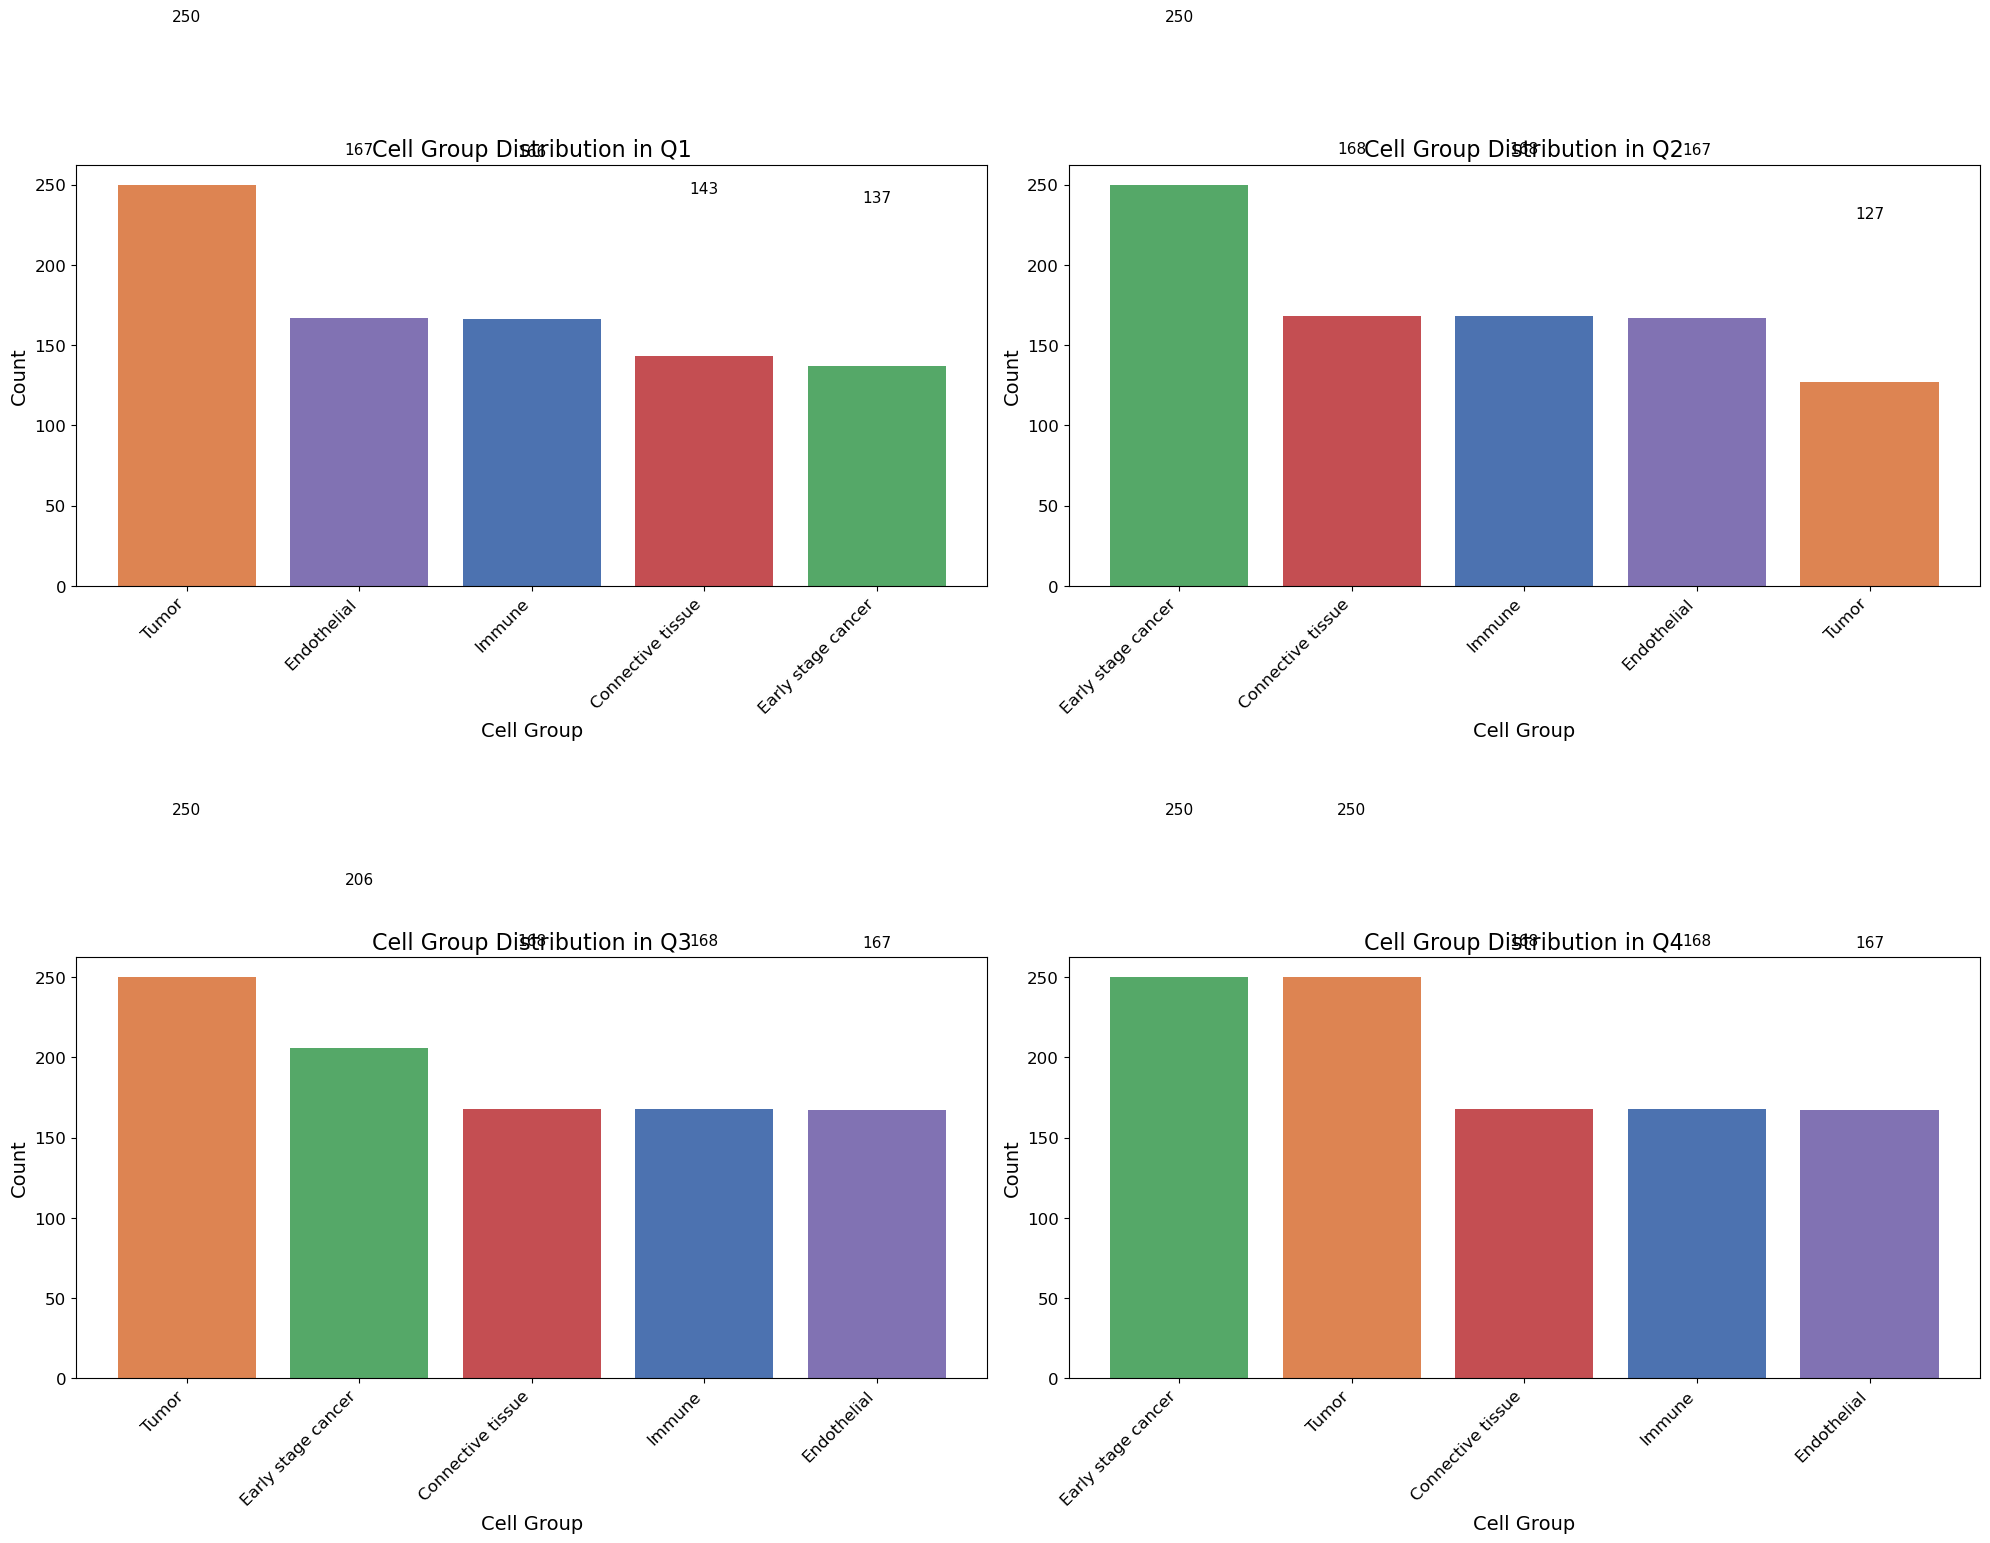

In [42]:
# Create separate plots for each fold (Q1-Q4) showing cell groups
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

folds = ['Q1', 'Q2', 'Q3', 'Q4']
colors = {
    'Immune': '#4C72B0',
    'Tumor': '#DD8452',
    'Early stage cancer': '#55A868',
    'Connective tissue': '#C44E52',
    'Endothelial': '#8172B3'
}

for i, fold in enumerate(folds):
    # Filter data for the current fold
    fold_data = group_counts2[group_counts2['Fold'] == fold]
    
    # Sort by count for better visualization
    fold_data = fold_data.sort_values('Count', ascending=False)
    
    # Create the bar plot with custom colors
    bars = axes[i].bar(fold_data['Cell Group'], fold_data['Count'], color=[colors.get(group, '#CCCCCC') for group in fold_data['Cell Group']])
    
    # Set title and labels
    axes[i].set_title(f'Cell Group Distribution in {fold}', fontsize=16)
    axes[i].set_xlabel('Cell Group', fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    
    # Add count values on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 100,
                 f'{int(height):,}', ha='center', va='bottom', fontsize=11)
    
    # Set tick parameters
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

#### Accross distributions

  Fold  Count
0   Q1    863
1   Q2    880
2   Q3    959
3   Q4   1003


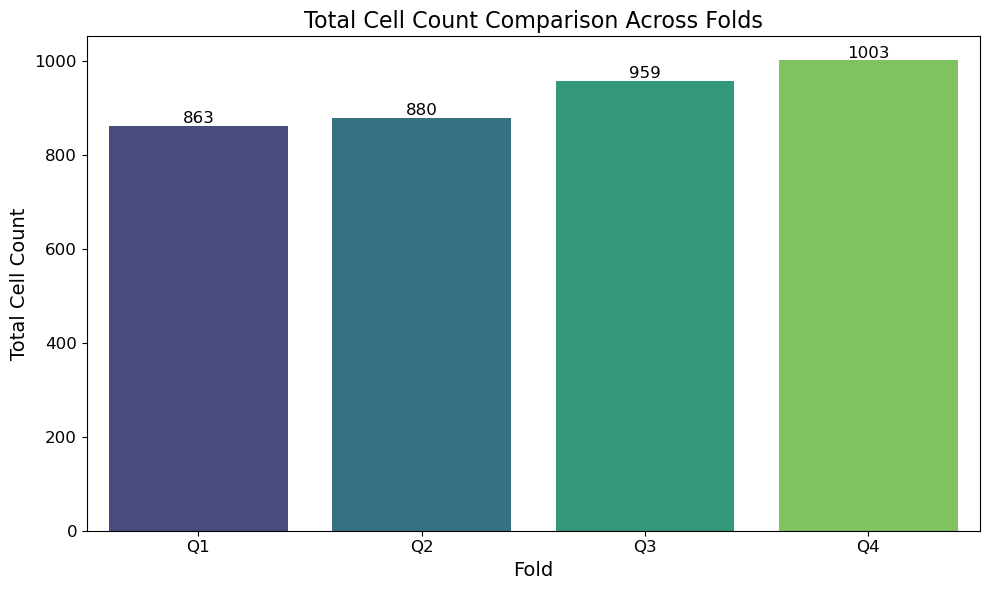

In [43]:
# Calculate the total number of cells in each fold
fold_totals = summary_df2.groupby('Fold')['Count'].sum().reset_index()
print(fold_totals.head())

# Create a bar chart to compare the total number of cells in each fold
plt.figure(figsize=(10, 6))
sns.barplot(x='Fold', y='Count', hue='Fold', data=fold_totals, palette='viridis', legend=False)
plt.title('Total Cell Count Comparison Across Folds', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Total Cell Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add numerical labels above each bar
for i, v in enumerate(fold_totals['Count']):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## Output images to subfolders
create and populate '{OUTPUT_BASE}/[Fold]/[Group]' with images

### Most images are simply copied

In [44]:
if (GENERATE_DATA == True):
    # delete the folder OUTPUT_BASE if it exists
    if os.path.exists(OUTPUT_BASE):
        shutil.rmtree(OUTPUT_BASE)
        print(f"Deleted existing dataset at '{OUTPUT_BASE}'")
    
    # Copy images to corresponding quadrant subfolders
    for _, row in stratified_down_df.iterrows():
        
        cluster = row["Cluster"].replace("&", "and").replace(" ", "_")
        quadrant = row["quadrant"]

        # TO OUTPUT INTO FOLDERS BASED ON CELL TYPE
        # dst_folder = os.path.join(OUTPUT_BASE, quadrant, cluster)
        # TO OUTPUT INTO FOLDERS BASED ON BINARY GROUP
        dst_folder = os.path.join(OUTPUT_BASE, quadrant, row["binary_group"])

        src_path = os.path.join(IMAGE_DIR, cluster, f"cell_{row['index']}_{IMAGE_SIZE}.png")
        os.makedirs(dst_folder, exist_ok=True)
        dst_path = os.path.join(dst_folder, f"cell_{row['index']}_{IMAGE_SIZE}.png")
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            # NOTE -> WILL SIMPLY SKIP _10, rather then adjusting sample based on this
            print(f"Warning: {src_path} not found. might be _10 not _100 pixel image in original data?")
    
    print(f"Produced new downsampled dataset at '{OUTPUT_BASE}'")

Deleted existing dataset at 'projectdata\images\100_stratified4fold_1000per_seed3888'
Produced new downsampled dataset at 'projectdata\images\100_stratified4fold_1000per_seed3888'


### Upsampled images are produced, and manually pasted into folders (AND REVISUALISED)

In [45]:
# go over samples in need of upsampling
for (fold, cell_type), desired_count in upsampling_required.items():
    # subset data
    subset_stratified_up_df = stratified_up_df[
        (stratified_up_df["quadrant"] == fold) & (stratified_up_df["Cluster"] == cell_type)
    ]
    print(f"Fold: {fold}, Cell Type: {cell_type}, Desired Count: {desired_count}, Actual Count: {len(subset_stratified_up_df)}")

    # fpath version of cluster/cell type
    cluster = cell_type.replace("&", "and").replace(" ", "_")

    # get raw images from src path
    raw_images = {}
    for _, row in subset_stratified_up_df.iterrows():
        src_path = os.path.join(IMAGE_DIR, cluster, f"cell_{row['index']}_{IMAGE_SIZE}.png")
        try:
            image = PIL.Image.open(src_path)
            raw_images[row['index']] = image
        except FileNotFoundError:
            print(f"Warning: {src_path} not found. Skipping this image.")

    # apply 5 transformations to each image, save these in memory
    tf_images = {}
    transformations = [
        lambda img: img.rotate(90, expand=True),
        lambda img: img.rotate(180, expand=True),
        lambda img: img.rotate(270, expand=True),
        lambda img: img.transpose(PIL.Image.FLIP_LEFT_RIGHT),
        lambda img: img.transpose(PIL.Image.FLIP_TOP_BOTTOM)
    ]
    for index, img in raw_images.items():
        for i, transformation in enumerate(transformations):
            tf_images[f"{index}_upsampled{i}"] = transformation(img)

    # Calculate the number of additional images needed
    additional_count = desired_count - len(subset_stratified_up_df)
    
    # Take a random sample of the required size from the transformed images
    if (additional_count <= len(tf_images)):
        random.seed(RANDOM_SEED)
        upsampled_images_l = random.sample(sorted(tf_images), k=additional_count)
        upsampled_images = {key: tf_images[key] for key in upsampled_images_l}
    else:
        print(f"Warning: Not enough transformed images for {cell_type} in {fold}. Using all available transformed images.")
        upsampled_images = tf_images

    # output results, and data to regenerate visualisations from before
    print(f"Upsampled to make {len(upsampled_images)} images, New count: {len(subset_stratified_up_df) + len(upsampled_images)} out of desired {desired_count}\n")
    # Update group_counts2 to increment the count for the specific fold and cell group
    group_counts2.loc[(group_counts2['Fold'] == fold) & (group_counts2['Cell Group'] == cell_group_map[cell_type]), 'Count'] += len(upsampled_images)
    fold_totals.loc[fold_totals['Fold'] == fold, 'Count'] += len(upsampled_images)
    
    # save them to same dest folder as before
    if (GENERATE_DATA == True):
        for label, img in upsampled_images.items():
            # this may throw errors, handle as they come
            dst_folder = os.path.join(OUTPUT_BASE, fold, group_to_binary_map[cell_group_map[cell_type]])
            dst_path = os.path.join(dst_folder, f"cell_{label}_{IMAGE_SIZE}.png")
            img.save(dst_path)
        print(f"Added upsampled images to dataset at '{OUTPUT_BASE}'")

Fold: Q1, Cell Type: DCIS 1, Desired Count: 125, Actual Count: 12
Upsampled to make 60 images, New count: 72 out of desired 125

Added upsampled images to dataset at 'projectdata\images\100_stratified4fold_1000per_seed3888'
Fold: Q1, Cell Type: Mast_Cells, Desired Count: 21, Actual Count: 19
Upsampled to make 2 images, New count: 21 out of desired 21

Added upsampled images to dataset at 'projectdata\images\100_stratified4fold_1000per_seed3888'
Fold: Q1, Cell Type: Myoepi_KRT15+, Desired Count: 42, Actual Count: 17
Upsampled to make 25 images, New count: 42 out of desired 42

Added upsampled images to dataset at 'projectdata\images\100_stratified4fold_1000per_seed3888'
Fold: Q2, Cell Type: Prolif_Invasive_Tumor, Desired Count: 125, Actual Count: 2
Upsampled to make 10 images, New count: 12 out of desired 125

Added upsampled images to dataset at 'projectdata\images\100_stratified4fold_1000per_seed3888'
Fold: Q3, Cell Type: DCIS 1, Desired Count: 125, Actual Count: 81
Upsampled to make 

#### Revisualise now

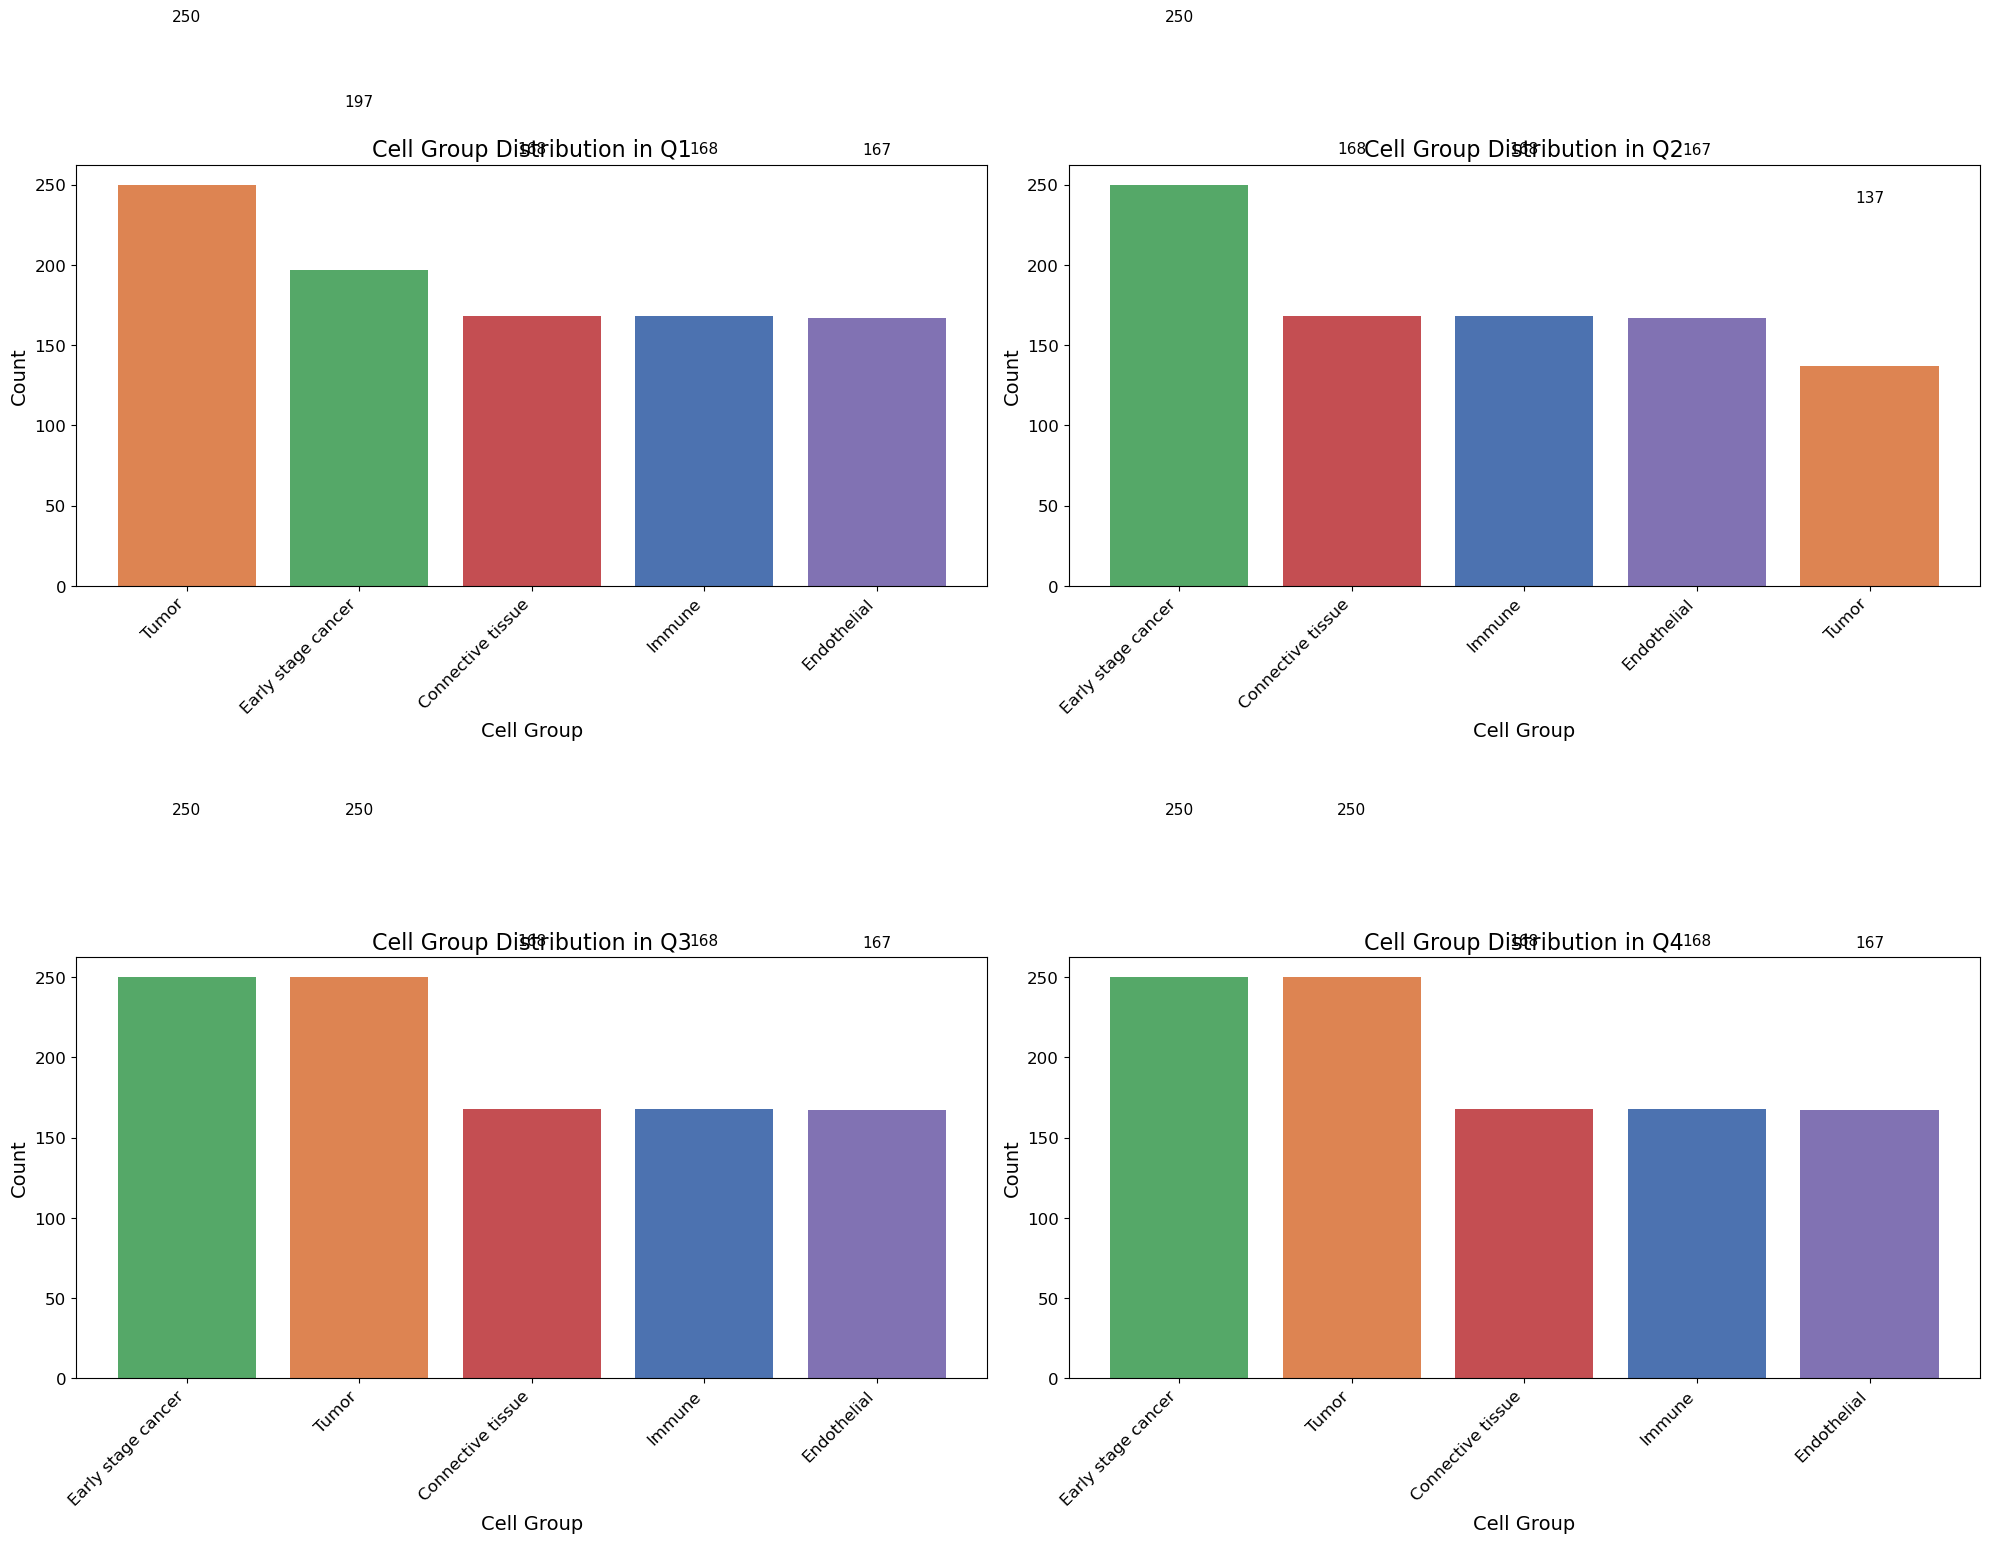

In [46]:
# Create separate plots for each fold (Q1-Q4) showing cell groups
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

folds = ['Q1', 'Q2', 'Q3', 'Q4']
colors = {
    'Immune': '#4C72B0',
    'Tumor': '#DD8452',
    'Early stage cancer': '#55A868',
    'Connective tissue': '#C44E52',
    'Endothelial': '#8172B3'
}

for i, fold in enumerate(folds):
    # Filter data for the current fold
    fold_data = group_counts2[group_counts2['Fold'] == fold]
    
    # Sort by count for better visualization
    fold_data = fold_data.sort_values('Count', ascending=False)
    
    # Create the bar plot with custom colors
    bars = axes[i].bar(fold_data['Cell Group'], fold_data['Count'], color=[colors.get(group, '#CCCCCC') for group in fold_data['Cell Group']])
    
    # Set title and labels
    axes[i].set_title(f'Cell Group Distribution in {fold}', fontsize=16)
    axes[i].set_xlabel('Cell Group', fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    
    # Add count values on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 100,
                 f'{int(height):,}', ha='center', va='bottom', fontsize=11)
    
    # Set tick parameters
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

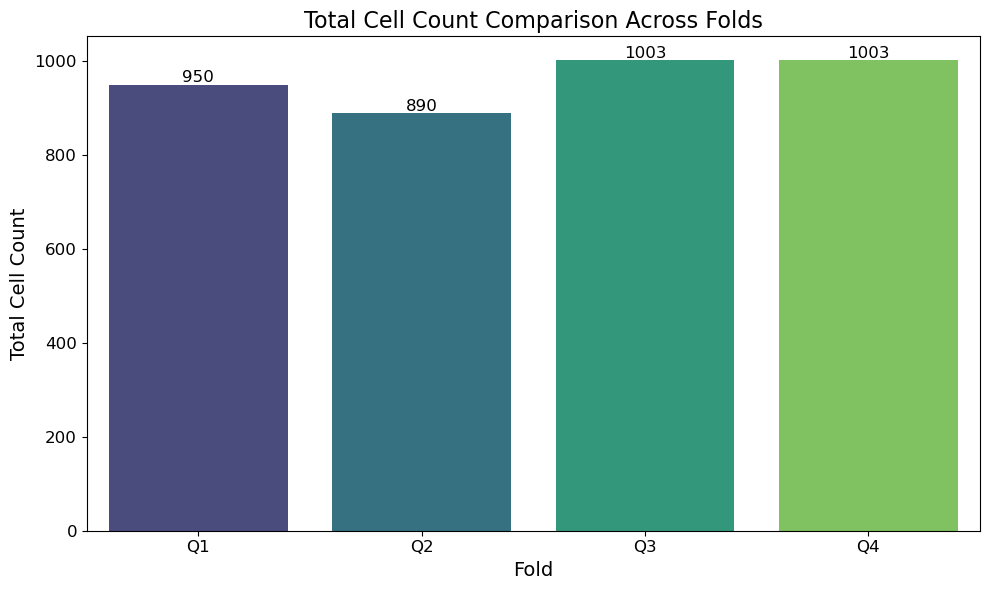

In [47]:
# Create a bar chart to compare the total number of cells in each fold
plt.figure(figsize=(10, 6))
sns.barplot(x='Fold', y='Count', hue='Fold', data=fold_totals, palette='viridis', legend=False)
plt.title('Total Cell Count Comparison Across Folds', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Total Cell Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add numerical labels above each bar
for i, v in enumerate(fold_totals['Count']):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

### Empty images are added as a new class
NOT BINARY CLASSIFICATION ANYMORE.

each quadrant will have different 'empty' images, to avoid leakage, but this might lead to weird results cos each fold has a different definition of 'empty'

#### First, visualise corners given MAX_IMAGE_SIZE, EMPTY_CLASS_SIZE 
These should actually be empty areas

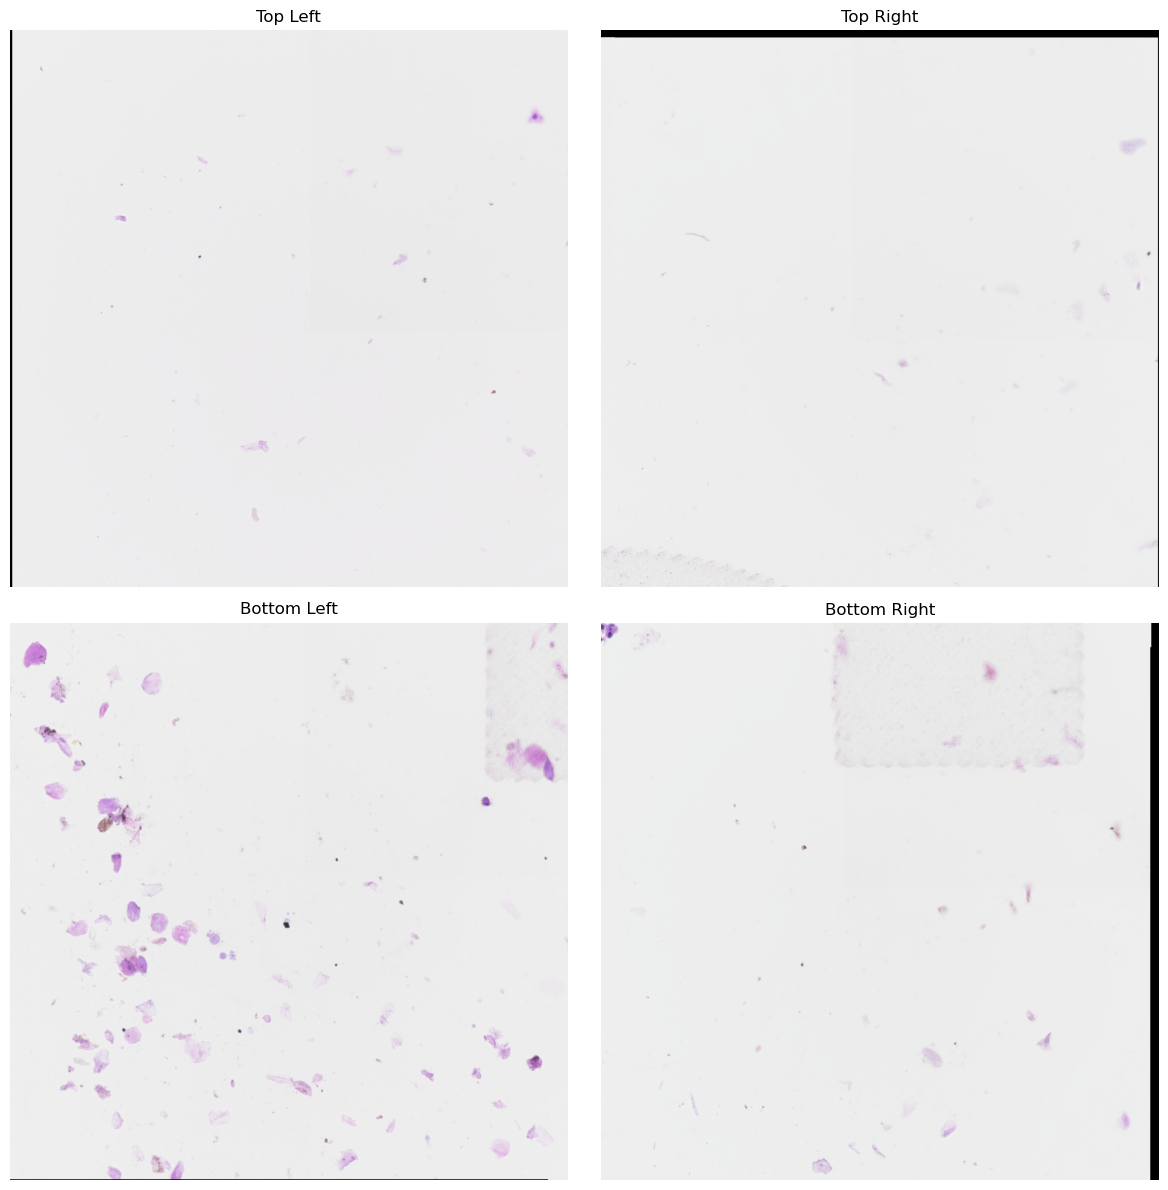

In [48]:
# Increase the limit for large images
PIL.Image.MAX_IMAGE_PIXELS = None  # Set to None to remove the limit

# open image
big_image = PIL.Image.open(BIG_IMAGE_PATH)
width, height = big_image.size

# calculate the size of the cropped images
crop_size = MAX_IMAGE_SIZE * int(math.sqrt(EMPTY_CLASS_SIZE)) # checked to be perfect square already

# Define the coordinates for the four corners
top_left = (0, 0, crop_size, crop_size)
top_right = (width - crop_size, 0, width, crop_size)
bottom_left = (0, height - crop_size, crop_size, height)
bottom_right = (width - crop_size, height - crop_size, width, height)

# Crop the big image
empty_regions = {}
empty_regions["Q1"] = big_image.crop(top_left).copy()
empty_regions["Q2"] = big_image.crop(top_right).copy()
empty_regions["Q3"] = big_image.crop(bottom_left).copy()
empty_regions["Q4"] = big_image.crop(bottom_right).copy()

big_image.close()
del big_image # free up memory

# Visualize the cropped images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0, 0].imshow(empty_regions["Q1"])
axes[0, 0].set_title("Top Left")
axes[0, 1].imshow(empty_regions["Q2"])
axes[0, 1].set_title("Top Right")
axes[1, 0].imshow(empty_regions["Q3"])
axes[1, 0].set_title("Bottom Left")
axes[1, 1].imshow(empty_regions["Q4"])
axes[1, 1].set_title("Bottom Right")

for ax in axes.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()



Validate that the purple dots in bottom left are not identified cells


In [49]:
# bottom left corresponds to 3rd printed point, with axis-0 maximum important for larger numbers for this coord (y values)
# relavant limits: (axis-1, axis-0, axis-1, axis-0)
print(top_left, top_right, bottom_left, bottom_right)
print(image_df["axis-1"].min(), image_df["axis-1"].max()) # x coord, width
print(image_df["axis-0"].min(), image_df["axis-0"].max()) # y coord, height

(0, 0, 2240, 2240) (28546, 0, 30786, 2240) (0, 22001, 2240, 24241) (28546, 22001, 30786, 24241)
5952.905699462583 26859.595389370454
6736.853637707163 21757.47116614583


Split corners into MAX_IMAGE_SIZE x MAX_IMAGE_SIZE chunks, and save the images

In [50]:
corner_names = {"Q1": "topleft", "Q2": "topright", "Q3": "bottomleft", "Q4": "bottomright"}

# Split corners into MAX_IMAGE_SIZE x MAX_IMAGE_SIZE chunks, and save the images
for quadrant, corner_image in empty_regions.items():
    for i in range(0, crop_size, MAX_IMAGE_SIZE):
        for j in range(0, crop_size, MAX_IMAGE_SIZE):
            # Define the box for cropping
            box = (i, j, i + MAX_IMAGE_SIZE, j + MAX_IMAGE_SIZE)
            cropped_image = corner_image.crop(box)

            if (GENERATE_DATA == True):
                # Save the cropped image
                dst_folder = os.path.join(OUTPUT_BASE, quadrant, "Empty")
                os.makedirs(dst_folder, exist_ok=True)
                dst_path = os.path.join(dst_folder, f"{corner_names[quadrant]}_{int(i/MAX_IMAGE_SIZE)}_{int(j/MAX_IMAGE_SIZE)}.png")
                cropped_image.save(dst_path)
                
if (GENERATE_DATA == True):                 
    print(f"Added empty image class (size: {EMPTY_CLASS_SIZE} x 4 folds) to dataset at '{OUTPUT_BASE}'")

Added empty image class (size: 100 x 4 folds) to dataset at 'projectdata\images\100_stratified4fold_1000per_seed3888'
